In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize, RandGaussianNoise
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm
import cv2
import pandas as pd

In [2]:
device = torch.device("cuda:0")
device2 = torch.device("cpu")

In [3]:
dirCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_COVID'
dirNonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_NonCOVID'

In [4]:
class CTCOVIDDataset(Dataset):
    def __init__(self, dirCOVID, dirNonCOVID, transforms = None, data = None, kfold = False):
        self.IMG_SIZE = 224
        self.valSplit = 0.1
        self.transforms = transforms
        self.data = data
        self.kfold = kfold
        self.COVID = dirCOVID
        self.NonCOVID = dirNonCOVID
        self.LABELS = {self.NonCOVID:0, self.COVID:1}
        self.training_data = []
        
        for label in self.LABELS:
            for f in tqdm(os.listdir(label)):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), self.LABELS[label]])
                
        np.random.shuffle(self.training_data)
        
        #MASSIVE IF STATEMENT FOR K fOLD (if k-fold then you need train and test set)
        if self.kfold == False:
            self.valSize = int(self.valSplit*len(self.training_data))

            self.X_val = torch.Tensor([i[0] for i in self.training_data[0:self.valSize]]).view(-1, 3, 224, 224)
            self.X_val/=255
            self.y_val = torch.Tensor([i[1] for i in self.training_data[0:self.valSize]])

            self.X_test = torch.Tensor([i[0] for i in self.training_data[self.valSize: self.valSize+self.valSize]]).view(-1, 3, 224, 224)
            self.X_test/=255
            self.y_test = torch.Tensor([i[1] for i in self.training_data[self.valSize: self.valSize+self.valSize]])

            self.X_train = torch.Tensor([i[0] for i in self.training_data[self.valSize+self.valSize:]]).view(-1, 3, 224, 224)
            self.X_train/=255
            self.y_train = torch.Tensor([i[1] for i in self.training_data[self.valSize+self.valSize:]])
        #MASSIVE ELIF STATEMENT FOR KFOLD (if no k fold then you need train, test and validation sets)
        
        else:
            
            self.X_train = torch.Tensor([i[0] for i in self.training_data]).view(-1, 3, 224, 224)
            self.X_train/=255
            self.y_train = torch.Tensor([i[1] for i in self.training_data])

    def __len__(self):
        
        if self.kfold == False:
            if self.data == 'train':
                return self.y_train.shape[0]
            elif self.data == 'val':
                return self.y_val.shape[0]
            elif self.data == 'test':
                return self.y_test.shape[0]
        else:
            if self.data == 'x_split':
                return self.X_train.shape[0]
            elif self.data == 'y_split':
                return self.y_train.shape[0]

    def __getitem__(self, idx):
        
        if self.kfold == False:
            if self.data == 'train':
                return self.X_train[idx], self.y_train[idx]
            elif self.data == 'val':
                return self.X_val[idx], self.y_val[idx]
            elif self.data == 'test':
                return self.X_test[idx], self.y_test[idx]
        else:
            if self.data == 'x_split':
                return self.X_train[idx]
            elif self.data == 'y_split':
                return self.y_train[idx]


In [5]:
#Tune the transforms
train_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(degrees=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    RandGaussianNoise(prob = 0.5),
    Resize(spatial_size=(224, 224)),
    ToTensor()
])

val_transforms = Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    ToTensor()
])

In [6]:
train_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = train_transforms, data = 'train')
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True) #Tune batch size

val_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'val')
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

test_ds = CTCOVIDDataset(dirCOVID, dirNonCOVID, transforms = val_transforms, data = 'test')
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

100%|██████████| 346/346 [00:03<00:00, 110.45it/s]


KeyboardInterrupt: 

In [7]:
print("Training Data Size:", train_ds.__len__())
print("Validation Data Size:", val_ds.__len__())
print("Testing Data Size:", test_ds.__len__())

Training Data Size: 595
Validation Data Size: 74
Testing Data Size: 74


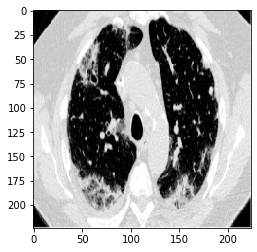

In [8]:
#Implementation Without K-Fold
img1 = 0
for batch in train_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

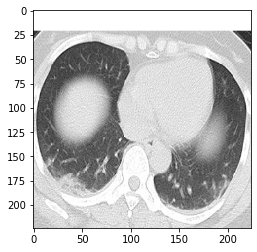

In [9]:
#Implementation Without K-Fold
img2 = 0
for batch in val_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

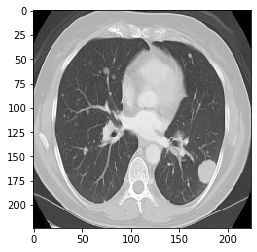

In [10]:
#Implementation Without K-Fold
img = 0
for batch in test_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

In [11]:
def validation(model, val_loader, criterion): #No KF validation
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(val_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        
        for index, i in enumerate(output):
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    return test_loss, accuracy

In [12]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, scheduler = None): #No KF training loop
    plot_train_loss = []
    plot_val_loss = []
    plot_train_acc = []
    plot_val_acc = []
    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        train_loss = 0
        for data in tqdm(train_loader):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1
        
        #scheduler.step()
        model.eval()
                
        with torch.no_grad():
            val_loss, val_acc = validation(model, val_loader, criterion)
                    
        train_acc = correct/total
        
        print("Training Loss:", train_loss)
        plot_train_loss.append(train_loss)
        
        print("Training Accuracy:", train_acc)
        plot_train_acc.append(train_acc)
        
        print("Validation Loss:", val_loss)
        plot_val_loss.append(val_loss)
        
        print("Validation Accuracy:", val_acc)
        plot_val_acc.append(val_acc)
        
        model.train()
    
    plot_train_loss = np.array(plot_train_loss) 
    plot_val_loss = np.array(plot_val_loss)
    plot_train_acc = np.array(plot_train_acc)
    plot_val_acc = np.array(plot_val_acc)
    
    return plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc
        

In [13]:
def load_model_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    
    return model

In [14]:
PRETRAINED = True

if PRETRAINED:
    MODEL_PATH = 'vgg19.pth'
    model = load_model_checkpoint(MODEL_PATH)

else:
    
    '''
    #####################################################################
    #VGG16: 30-35 epochs, Training Accuracy: 95%, Validation Accuracy: 93%
    #####################################################################
    
    for param in vgg16.parameters():
        param.requires_grad = False

    layers_vgg16 = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 512)),
        ('activation1', nn.ReLU()),
        ('dropout1', nn.Dropout()),
        ('fc2', nn.Linear(512, 256)),
        ('activation2', nn.ReLU()),
        ('dropout2', nn.Dropout()),
        ('fc3', nn.Linear(256, 128)),
        ('activation3', nn.ReLU()),
        ('dropout3', nn.Dropout()),
        ('fc4', nn.Linear(128, 2)),
        ('out', nn.Sigmoid())

    ])).to(device)

    vgg16.classifier = layers_vgg16
    
    ######################################################################################
    #ResNet-34 model: Training Accuracy: ~50%, Validation Accuracy: ~50% (both oscillating)
    ######################################################################################
    
    for param in resnet.parameters():
        param.requires_grad = False

    layers_resnet = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 400)),
        ('activation1', nn.ReLU()),
        ('dropout1', nn.Dropout()),
        ('fc2', nn.Linear(400, 256)),
        ('activation2', nn.ReLU()),
        ('dropout2', nn.Dropout()),
        ('fc3', nn.Linear(256, 128)),
        ('activation3', nn.ReLU()),
        ('dropout3', nn.Dropout()),
        ('fc4', nn.Linear(128, 2)),
        ('out', nn.Sigmoid())

    ])).to(device)

    resnet.avgpool = nn.AdaptiveAvgPool2d(output_size = (7, 7))
    resnet.fc = layers_resnet
    '''
    
    ##########################################################
    #VGG19: Training Accuracy: 94%, Validation Accuracy: ~91%
    ##########################################################
    
    model = torchvision.models.vgg19(pretrained = True).to(device)
    
    for param in model.parameters():
        param.requires_grad = False

    layers_vgg19 = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 512)),
        ('activation1', nn.ReLU()),
        ('dropout1', nn.Dropout()),
        ('fc2', nn.Linear(512, 256)),
        ('activation2', nn.ReLU()),
        ('dropout2', nn.Dropout()),
        ('fc3', nn.Linear(256, 128)),
        ('activation3', nn.ReLU()),
        ('dropout3', nn.Dropout()),
        ('fc4', nn.Linear(128, 2)),
        ('out', nn.Sigmoid())

    ])).to(device)

    model.classifier = layers_vgg19

    #learning_rate = 0.1
    epochs = 30

    optimizer = optim.Adam(model.parameters())
    #scheduler = ExponentialLR(optimizer, 0.9)
    criterion = nn.CrossEntropyLoss()

    plot_train_loss, plot_val_loss, plot_train_acc, plot_val_acc = train(model, train_loader, 
                                                                         val_loader, optimizer, criterion, epochs)
    
    checkpoints = {
        'model' : model,
        'input_size' : (224, 224, 3),
        'output_size' : 2,
        'state_dict' : model.state_dict()
    }

    torch.save(checkpoints, 'vgg19.pth')

In [15]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = model.to(device2)
        
        for param in self.vgg.parameters():
            param.requires_grad = True
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [16]:
def plot_train_val(num_epochs, fig_size):
    plot_epochs = np.array([i for i in range(1, num_epochs+1)])
    fig, axs = plt.subplots(2, 2)
    
    axs[0, 0].plot(plot_epochs, plot_train_loss)
    axs[0, 0].set_title("Training Loss")
    
    axs[1, 0].plot(plot_epochs, plot_val_loss)
    axs[1, 0].set_title("Validation Loss")
    
    axs[0, 1].plot(plot_epochs, plot_train_acc)
    axs[0, 1].set_title("Training Accuracy")
    
    axs[1, 1].plot(plot_epochs, plot_val_acc)
    axs[1, 1].set_title("Validation Accuracy")
    
    fig.set_figheight(fig_size[0])
    fig.set_figwidth(fig_size[1])
    
#plot_train_val(epochs, (10, 10))

In [17]:
def test(model, test_loader, criterion):
    y_proba = []
    y_truth = []
    test_loss = 0
    total = 0
    correct = 0
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        test_loss += criterion(output, y.long()).item()
        for index, i in enumerate(output):
            y_proba.append(i[1])
            y_truth.append(y[index])
            if torch.argmax(i) == y[index]:
                correct+=1
            total+=1
                
    accuracy = correct/total
    
    y_proba_out = np.array([float(y_proba[i]) for i in range(len(y_proba))])
    y_truth_out = np.array([float(y_truth[i]) for i in range(len(y_truth))])
    
    return test_loss, accuracy, y_proba_out, y_truth_out

In [18]:
loss, acc, y_proba, y_truth = test(model, test_loader, criterion = nn.CrossEntropyLoss())

100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


In [25]:
acc

0.9324324324324325

In [19]:
#torch.squeeze(torch.Tensor([1]))
np.squeeze(np.array(0))

array(0)

In [22]:
def display_FP_FN(model, test_loader, criterion, display = 'fp'):
    fp = []
    fn = []
    for data in tqdm(test_loader):
        X, y = data[0].to(device), data[1].to(device)
        output = model(X)
        for index, i in enumerate(output):
            if torch.argmax(i.to(device2)) == torch.Tensor([1]) and y[index].to(device2) == torch.Tensor([0]):
                fp.append(X[index])
            elif torch.argmax(i.to(device2)) == torch.Tensor([0]) and y[index].to(device2) == torch.Tensor([1]):
                fn.append(X[index])
    
    fig = plt.figure()
    
    if display == 'fp':
        n_img = len(fp)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fp):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')
    
            
    elif display == 'fn':
        n_img = len(fn)
        cols = int(math.sqrt(n_img))
        for idx, img in enumerate(fn):
            a = fig.add_subplot(cols, np.ceil(n_img/float(cols)), idx + 1)
            plt.imshow(img.view(224, 224, 3).cpu())
            plt.axis('off')
    

100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


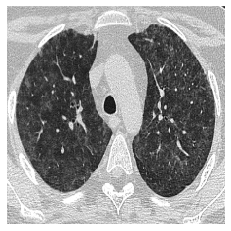

In [23]:
display_FP_FN(model, test_loader, criterion = nn.CrossEntropyLoss(), display = 'fp')

array([[32,  4],
       [ 1, 37]], dtype=int64)

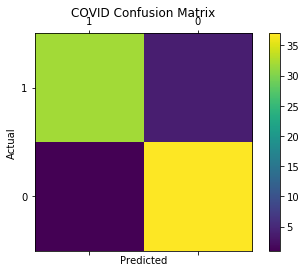

In [24]:
def get_confusion_matrix(y_truth, y_proba, labels):
    y_in = np.array([round(i) for i in y_proba])
    cm = confusion_matrix(y_truth, y_in, labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('COVID Confusion Matrix')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    return cm

get_confusion_matrix(y_truth, y_proba, labels = [1, 0])

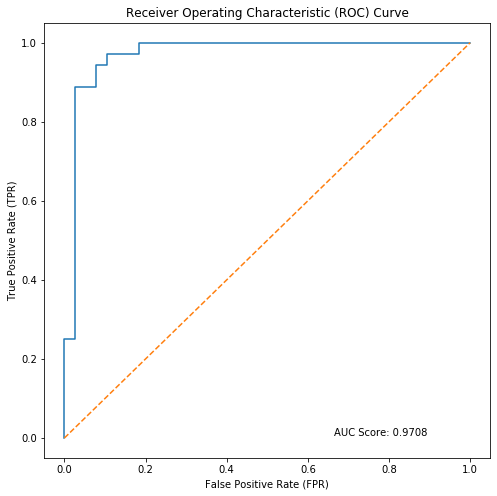

In [26]:
def plot_ROCAUC_curve(y_truth, y_proba, fig_size):
    fpr, tpr, threshold = roc_curve(y_truth, y_proba)
    auc_score = roc_auc_score(y_truth, y_proba)
    txt_box = "AUC Score: " + str(round(auc_score, 4))
    plt.figure(figsize=fig_size)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'--')
    plt.annotate(txt_box, xy=(0.65, 0.05), xycoords='axes fraction')
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    
plot_ROCAUC_curve(y_truth, y_proba, (8, 8))

In [27]:
def showCAM(model, dataloader):
    model.eval()
    img, _ = next(iter(dataloader))
    pred = model(img)
    idx = torch.argmax(pred)
    
    pred[:, 1].backward()

    # pull the gradients out of the model
    gradients = model.get_activations_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = model.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(512):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    
    npmap = heatmap.numpy()
    heat_mp = cv2.resize(npmap, (224, 224))
    heat_map = np.uint8(255*heat_mp)
    
    colored_map = cv2.cvtColor(heat_map, cv2.COLOR_GRAY2RGB)
    final_heatmap = cv2.applyColorMap(colored_map, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img.view(224, 224, 3).numpy(), 0.5, final_heatmap, 0.5, 0, dtype=cv2.CV_64F)

    #superimposed_img = final_heatmap + img.view(224, 224,3).numpy()
    
    f = plt.figure(figsize = (10, 10))
    f.add_subplot(1,3, 1)
    plt.imshow(img.view(224,224,3))
    f.add_subplot(1,3, 2)
    plt.imshow(final_heatmap)
    f.add_subplot(1,3, 3)
    plt.imshow(superimposed_img)
    plt.show(block=True)

In [28]:
cam_loader = DataLoader(test_ds, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


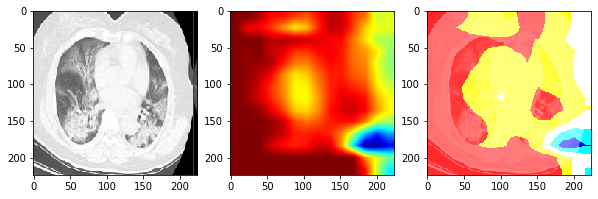

In [29]:
vgg = VGG19()
showCAM(vgg, cam_loader)

In [43]:
####WORK ONNNN######
from scipy.stats import chi2
def hl_test(y_truth, y_proba):
    #y_truth = list(y_truth)
    #y_proba = list(y_proba)
    hltest = (((y_truth - y_proba)**2 / y_proba) + ((y_truth - y_proba)**2 / y_proba)).sum()
    pval = 1 - chi2.cdf(hltest, 1)
    
    return hltest, pval

hl, pval = hl_test(y_truth, y_proba)
pval

0.0

In [ ]:
expectedCOVID = []
expectedNonCOVID = []
observedCOVID = []
observedNonCOVID = []

for i in range(len(y_proba)):
    if round(y_proba[i]) == 1:
        observedCOVID.append(y_proba[i])
    elif round(y_proba[i]) == 0:
        observedNonCOVID.append(y_proba[i])
for i in range(len(y_truth)):
    if y_truth[i] == 1:
        expectedCOVID.append(y_truth[i])
    elif y_truth[i] == 0:
        expected
        